In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [180]:
from sklearn import tree
from sklearn.preprocessing import OneHotEncoder
from collections import Counter

In [181]:
dataset_file = '../datasets/Carseats.csv'
data = pd.read_csv(dataset_file)
data.Urban = data.Urban.apply(lambda v: 1 if v == 'Yes' else 0)
data.US = data.US.apply(lambda v: 1 if v == 'Yes' else 0)
data = pd.concat([data, pd.get_dummies(data.ShelveLoc, prefix='ShelveLoc', prefix_sep='')], axis=1)
data.drop(['ShelveLoc'], axis=1, inplace=True)
data['High'] = data.Sales.apply(lambda v: 1 if v > 8 else 0)
data.head()

,Sales,CompPrice,Income,Advertising,Population,Price,Age,Education,Urban,US,ShelveLocBad,ShelveLocGood,ShelveLocMedium,High
0,9.50,138,73,11,276,120,42,17,1,1,1,0,0,1
1,11.22,111,48,16,260,83,65,10,1,1,0,1,0,1
2,10.06,113,35,10,269,80,59,12,1,1,0,0,1,1
3,7.40,117,100,4,466,97,55,14,1,1,0,0,1,0
4,4.15,141,64,3,340,128,38,13,1,0,1,0,0,0


In [182]:
model = tree.DecisionTreeClassifier(max_leaf_nodes=27).fit(data.drop(['Sales', 'High'], axis=1), data.High)

In [183]:
leaves_count = Counter()
n1 = Counter()
n0 = Counter()
for X, y in zip(data.drop(['Sales', 'High'], axis=1).to_numpy(), data.High):
    terminal = model.apply(X.reshape(1, -1))[0]
    leaves_count[terminal] += 1
    if y == 1:
        n1[terminal] += 1
    else:
        n0[terminal] += 1

deviance = -2 * np.sum([n1[leaf] * np.log(n1[leaf] / leaves_count[leaf] + 1e-6) + \
                        n0[leaf] * np.log(n0[leaf] / leaves_count[leaf] + 1e-6) 
                        for leaf in leaves_count.keys()])

Terminal nodes: 27
Training error: 0.0700
Mean deviance: 0.4636


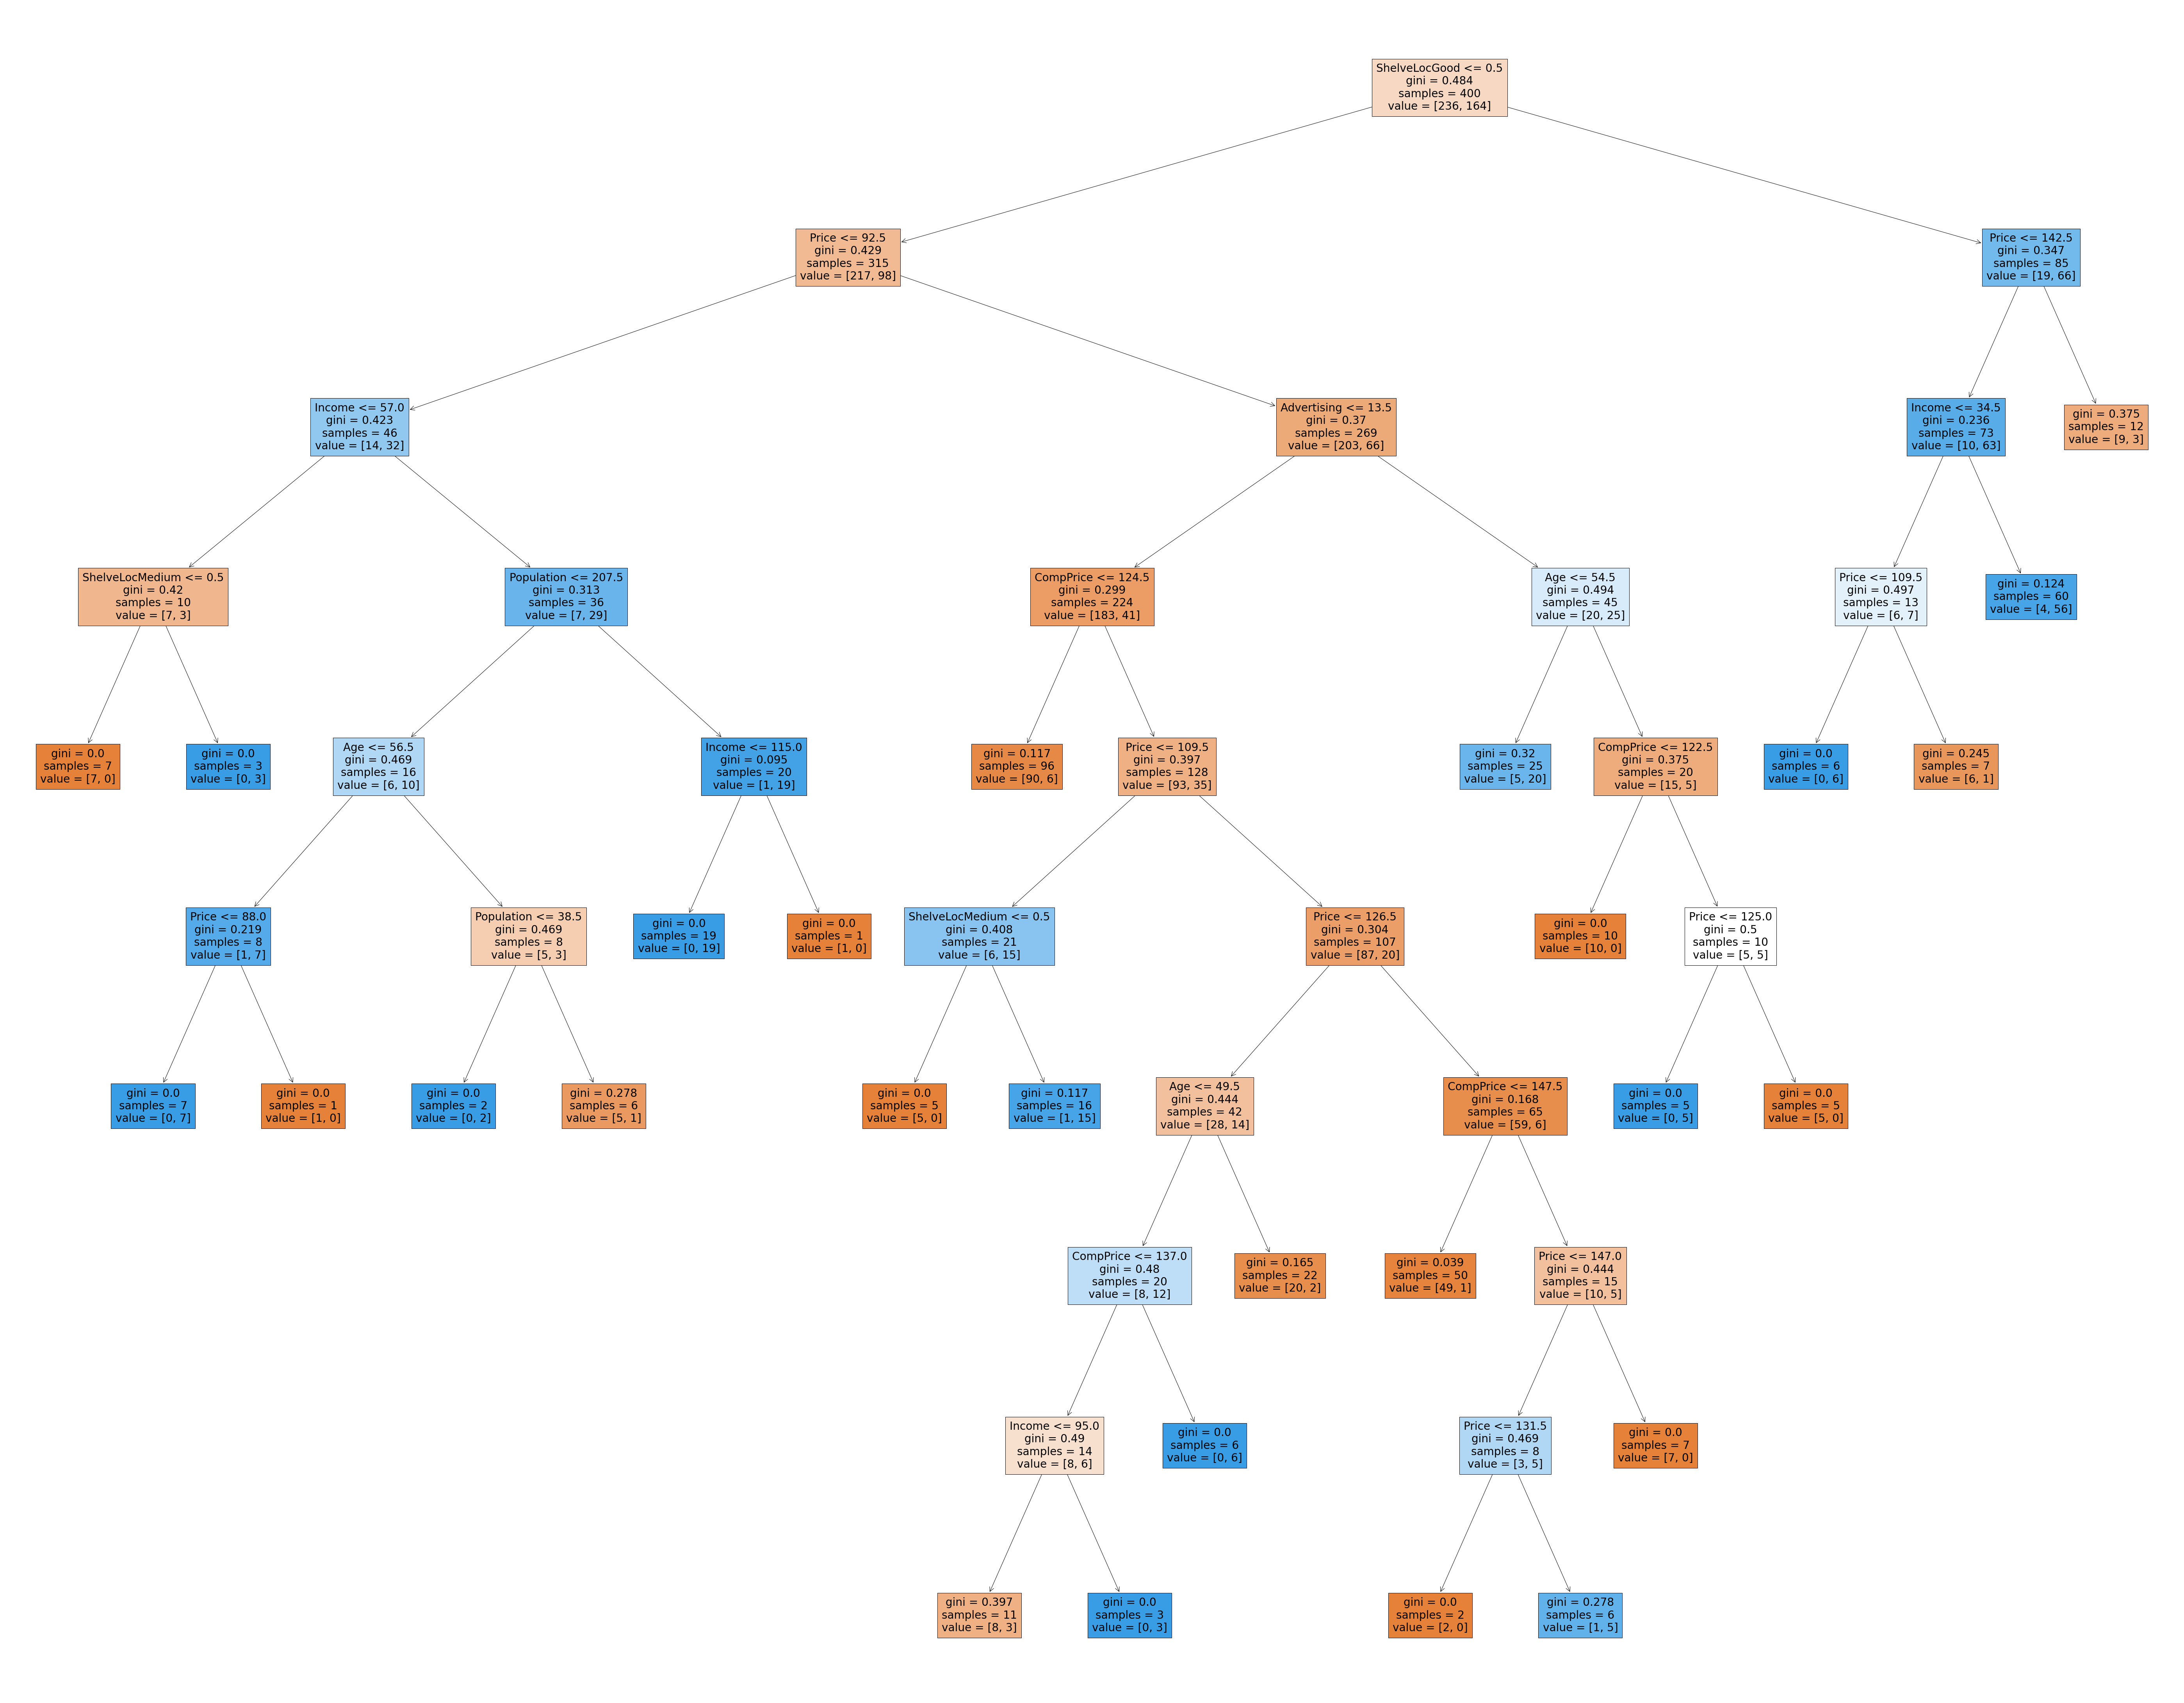

In [193]:
plt.figure(figsize=(100, 80))
cols = data.drop(['Sales', 'High'], axis=1).columns
tree.plot_tree(model, feature_names=cols, filled=True)
print(f'Terminal nodes: {model.get_n_leaves()}')
print(f"Training error: {1 - model.score(data.drop(['Sales', 'High'], axis=1), data.High):.4f}")
print(f"Mean deviance: {deviance / (data.High.size - model.max_leaf_nodes):.4f}")

In [202]:
print(tree.export_text(model, feature_names=list(cols)))

|--- ShelveLocGood <= 0.50
|   |--- Price <= 92.50
|   |   |--- Income <= 57.00
|   |   |   |--- ShelveLocMedium <= 0.50
|   |   |   |   |--- class: 0
|   |   |   |--- ShelveLocMedium >  0.50
|   |   |   |   |--- class: 1
|   |   |--- Income >  57.00
|   |   |   |--- Population <= 207.50
|   |   |   |   |--- Age <= 56.50
|   |   |   |   |   |--- Price <= 88.00
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |--- Price >  88.00
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |--- Age >  56.50
|   |   |   |   |   |--- Population <= 38.50
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |--- Population >  38.50
|   |   |   |   |   |   |--- class: 0
|   |   |   |--- Population >  207.50
|   |   |   |   |--- Income <= 115.00
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- Income >  115.00
|   |   |   |   |   |--- class: 0
|   |--- Price >  92.50
|   |   |--- Advertising <= 13.50
|   |   |   |--- CompPrice <= 124.50
|   |   |   |   |--- class: 0
|   |   |   |-

In [253]:
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import confusion_matrix, accuracy_score

In [294]:
train, test = train_test_split(data, test_size=.1, random_state=228)

In [295]:
model = tree.DecisionTreeClassifier(max_leaf_nodes=27).fit(train.drop(['Sales', 'High'], axis=1), train.High)
cmx = confusion_matrix(test.High, model.predict(test.drop(['Sales', 'High'], axis=1))).T
acc = accuracy_score(test.High, model.predict(test.drop(['Sales', 'High'], axis=1)))
print(f'TN: {cmx[0, 0]}, FN: {cmx[0, 1]}, FP: {cmx[1, 0]}, TP: {cmx[1, 1]}')
print(f'Accuracy score: {acc}')

TN: 21, FN: 4, FP: 3, TP: 12
Accuracy score: 0.825


Text(0.5, 1.0, 'Best: 0.013079710144927533')

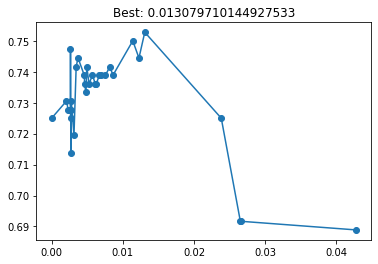

In [309]:
cv = KFold(n_splits=5, shuffle=True, random_state=1)
alphas = model.cost_complexity_pruning_path(train.drop(['Sales', 'High'], axis=1), train.High)['ccp_alphas'][:-1]
cv_errors = pd.DataFrame(dtype=float)
cv_fold = 0
for train_, test_ in cv.split(train):
    fold_errors = pd.Series(dtype=float, index = alphas)
    fold_leaves = pd.Series(dtype=float, index = alphas)
    for alpha in alphas:
        model = tree.DecisionTreeClassifier(ccp_alpha=alpha)
        model.fit(train.iloc[train_].drop(['Sales', 'High'], axis=1), train.iloc[train_].High)
        preds = model.predict(train.iloc[test_].drop(['Sales', 'High'], axis=1))
        fold_errors.loc[alpha] = accuracy_score(train.iloc[test_].High, preds)
        fold_leaves.loc[alpha] = model.get_n_leaves()
    cv_errors[cv_fold] = fold_errors
    cv_fold +=1

plt.plot(cv_errors.index, cv_errors.mean(axis=1), 'o-')
plt.xticks = alphas
best = cv_errors.mean(axis=1).idxmax()
plt.title(f'Best: {best}')

In [310]:
model = tree.DecisionTreeClassifier(ccp_alpha=best).fit(train.drop(['Sales', 'High'], axis=1), train.High)
cmx = confusion_matrix(test.High, model.predict(test.drop(['Sales', 'High'], axis=1))).T
acc = accuracy_score(test.High, model.predict(test.drop(['Sales', 'High'], axis=1)))
print(f'TN: {cmx[0, 0]}, FN: {cmx[0, 1]}, FP: {cmx[1, 0]}, TP: {cmx[1, 1]}')
print(f'Accuracy score: {acc}')

TN: 18, FN: 4, FP: 6, TP: 12
Accuracy score: 0.75


Text(0.5, 1.0, 'Best: 9.0')

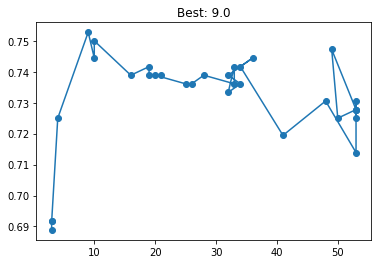

In [311]:
plt.plot(fold_leaves, cv_errors.mean(axis=1), 'o-')
best = cv_errors.mean(axis=1).idxmax()
plt.title(f'Best: {fold_leaves.loc[best]}')